In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(500)

In [2]:
df = pd.read_csv("data/ab_data.csv")

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
df.user_id.nunique()

290584

### Perform a Groupby to check how population is distributed among ‘old_landing_page’ and ‘new_landing_page’ - 

In [6]:
df.groupby(['group','landing_page']).count()['converted']

group      landing_page
control    new_page          1928
           old_page        145274
treatment  new_page        145311
           old_page          1965
Name: converted, dtype: int64

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### Calculating conversion rate in different scenarios and making sure data is distributed equally - 

In [8]:
all_conv = "%.4f" % (df.converted.sum() / df.converted.count())

all_conv

'0.1197'

In [9]:
control_conv = df.query("group == 'control'")['converted'].sum() / df.query("group == 'control'")['converted'].count()

"%.4f" % control_conv

'0.1204'

In [10]:
treat_conv = df.query("group == 'treatment'")['converted'].sum() / df.query("group == 'treatment'")['converted'].count()

"%.4f" % treat_conv

'0.1189'

In [12]:
p_n = df.query('landing_page == "new_page"').user_id.nunique()/df.user_id.nunique()

"%.4f" % p_n

'0.5035'

### Probability Results: It seems to be that there is insufficient evidence to say that the new treatment page leads to more conversions than the control page. The difference of probability between control (12.03%) and treatment groups (11.88%) is tiny, especially when we compare them with the probability of individual conversion (11.97%)

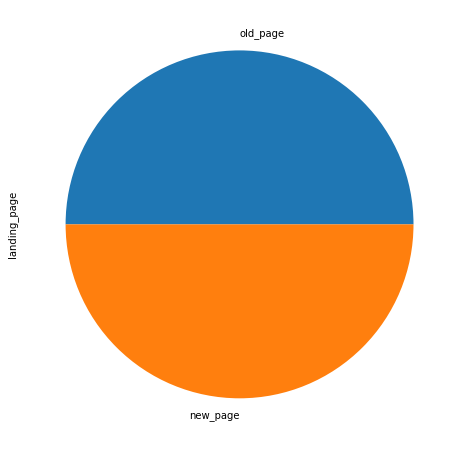

In [13]:
df['landing_page'].value_counts().plot(kind = 'pie', figsize = (8,8))

### We will consider making the decision only based on all the data provided. Further, we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. The null and alternative hypotheses follow below:
	

### We will assume under the null hypothesis, Pnew(treat_conv) and Pold(control_conv) both have "true" success rates equal to the converted success rate regardless of page -- that is Pnew and Pold are equal. Furthermore, we will assume they are equal to the converted rate in ab_data.csv regardless of the page. we will perform the sampling distribution for the difference in converted between the two pages over 20,000 iterations of calculating an estimate from the null.


In [14]:
# Calculate the probabilty that an individual received the new page
p_n = df.query('landing_page == "new_page"').user_id.nunique()/df.user_id.nunique()
#The probability that an individual received the new page is 50.00%
print("The probability that an individual received the new page is {0:.2%}".format(p_n))

The probability that an individual received the new page is 50.35%


### Let’s see what are our n_new, n_old - 

In [15]:
df.drop_duplicates(subset='user_id', keep='first', inplace=True)
# Use a sample size for each page equal to the ones in ab_data1.csv. 
df.groupby('landing_page').count()['user_id']

landing_page
new_page    145320
old_page    145264
Name: user_id, dtype: int64

In [18]:
n_new = df.query('landing_page == "new_page" ').count()[0]
n_old = df.query('landing_page == "old_page" ').count()[0]

In [19]:
print(n_new)
print(n_old)

145320
145264


In [20]:
df2 =df.drop(df.query('(group == "treatment" and landing_page != "new_page" ) or (group != "treatment" and landing_page == "new_page") or (group == "control" and landing_page != "old_page") or (group != "control" and landing_page == "old_page")').index)

In [21]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [22]:
df2.user_id.nunique()

288540

In [23]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


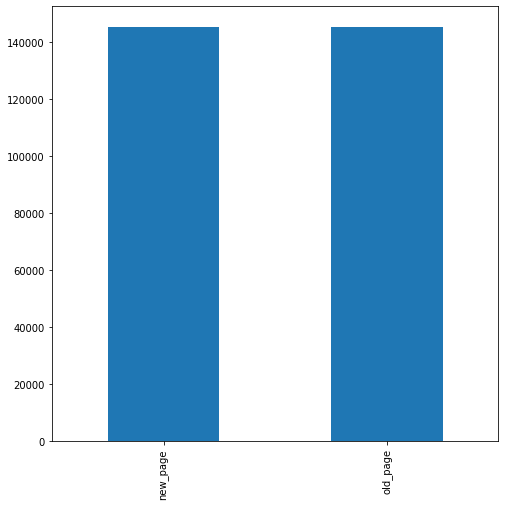

In [24]:
df['landing_page'].value_counts().plot(kind='bar', figsize=(8,8))

([<matplotlib.axis.XTick at 0x1c6f3228748>,
 <a list of 2 Text xticklabel objects>)

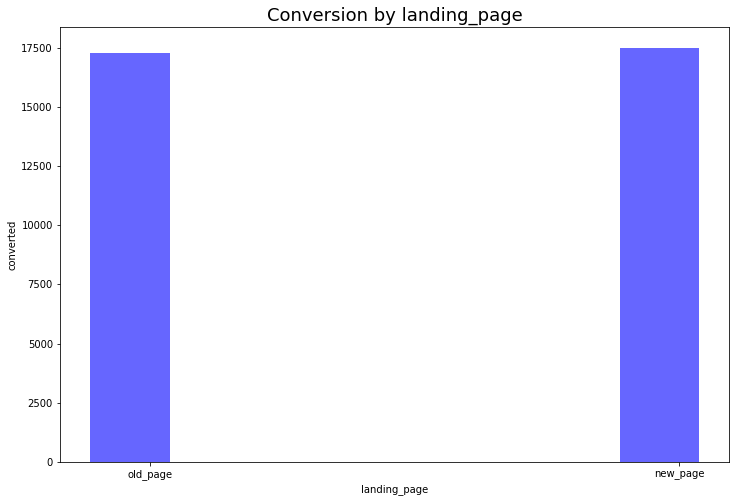

In [25]:
lan_rev =df.groupby('landing_page').sum()['converted']

ind = np.arange(len(lan_rev))  # the x locations for the groups
width = 0.15  

plt.subplots(figsize=(12,8))
gen_bars =plt.bar(ind, lan_rev, width, color='b', alpha=.6)
plt.ylabel('converted',size=10) # title and labels
plt.xlabel('landing_page',size=10)
plt.title('Conversion by landing_page',size=18)
locations = ind + width / 4  # xtick locations
labels = ['old_page', 'new_page']  # xtick labels
plt.xticks(locations, labels)

In [26]:
#Check duplicates rows
df2.user_id.duplicated().sum()

0

### Simulate 20,000 p_new - p_old values with random binomial


In [27]:
# Simulate 20,000 p_new - p_old values with random binomial

new_converted_simulation = np.random.binomial(n_new, treat_conv, 20000)/n_new
old_converted_simulation = np.random.binomial(n_old, control_conv, 20000)/n_old

In [28]:
p_diffs = new_converted_simulation - old_converted_simulation

In [29]:
p_diffs

array([-1.34022149e-03, -1.04403098e-03, -1.50519652e-03, ...,
       -2.18065531e-04,  1.92858618e-06, -1.79411040e-03])

In [30]:
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

In [31]:
p_diffs = np.array(p_diffs)

### Plot the p_diff

(array([  26.,  184.,  987., 2974., 5520., 5575., 3278., 1173.,  262.,
          21.]),
 array([-0.0061029 , -0.00518889, -0.00427488, -0.00336086, -0.00244685,
        -0.00153284, -0.00061882,  0.00029519,  0.0012092 ,  0.00212322,
         0.00303723]),
 <a list of 10 Patch objects>)

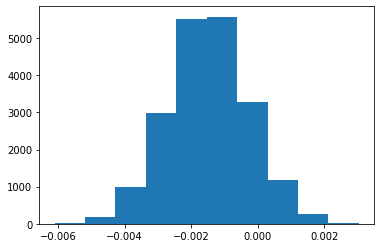

In [32]:
plt.hist(p_diffs)

In [33]:
# Calculate actual difference observed
new_convert = df2.query('converted == 1 and landing_page == "new_page"').count()[0]/n_new
old_convert = df2.query('converted == 1 and landing_page == "old_page"').count()[0]/n_old

In [34]:
obs_diff = new_convert - old_convert
obs_diff

-0.00152551697251338

In [35]:
#Check the proportion of the p_diffs are greater than the actual difference observed in ab_data.
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

### Now let’s calculate the actual Difference Observed - 

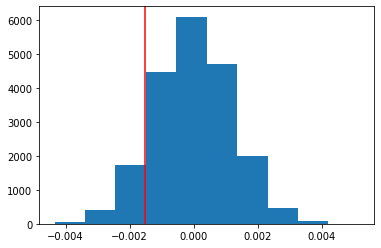

In [36]:
plt.hist(null_vals);
plt.axvline(x=obs_diff, color='red')

### Check as well as Plot the proportion of the p_diffs are greater than the actual difference observed in ab_data

In [37]:
(null_vals > obs_diff).mean()

0.89565

### Sample Distribution Analysis Results:
The proportion of the conversion rate differences were greater than the actual observed difference. The p-value is extremely large (89%) than the type I error rate (5%).That means we fail to reject the null hypothesis.

According to Wikipedia, p-value is the probability for a given statistical model that, when the null hypothesis is true, the statistical summary (such as the sample mean difference between two compared groups) would be the same as or of greater magnitude than the actual observed results.

When the p-value is low (in this project less than 5%), it suggests that the null hypothesis is not true, and we need to consider the alternative hypothesis. Finally, the p-value of 90% indicates that the actual page should be maintained


In [38]:
convert_old = df2.query('converted == 1 and landing_page == "old_page"').count()[0]
convert_new = df2.query('converted == 1 and landing_page == "new_page"').count()[0]
n_old = df2.query('landing_page == "old_page" ').count()[0]
n_new = df2.query('landing_page == "new_page" ').count()[0]

In [39]:
convert_old,convert_new,n_old,n_new

(17349, 17134, 144226, 144314)

In [40]:
import statsmodels.api as sm
from scipy.stats import norm

In [41]:
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]), np.array([n_new,n_old]), alternative = 'larger')

In [42]:
z_score, p_value

(-1.2942367891190543, 0.9022081785605929)

In [43]:
# Tells us how significant our z-score is
norm.cdf(z_score)

0.09779182143940718

In [44]:
norm.ppf(1-(0.05/2))
# Tells us what our critical value at 96% confidence is

1.959963984540054

### Z-test Results:
Since the z-score of 1.29 does not exceed the critical value of 1.96, we fail to reject the null hypothesis. The conversion rates of the old page is greater than or equal to the conversion rates of the new. Moreover, there was not a significant difference between the conversion rates of the new page and the conversion rates of the old page (>0.15%).

In [45]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [46]:
df2['intercept'] = 1
df2[['ab_page','old_page']] = pd.get_dummies(df2['landing_page'])
df2 = df2.drop('old_page', axis = 1)

In [47]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [48]:
#Create a model
log = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.365942
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               288540
Model:                          Logit   Df Residuals:                   288538
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Dec 2019   Pseudo R-squ.:               7.932e-06
Time:                        12:16:09   Log-Likelihood:            -1.0559e+05
converged:                       True   LL-Null:                   -1.0559e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1956
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9897      0.008   -245.805      0.000      -2.006      -1.974
ab_page       -0.0149      0.011     -1.294      0.196      -0.037       0.008
==============================================================================
"""

### Regression Analysis Results:

The p-value associated with ab_page is 0.19 and the p-value in Part II (A/B test) was 0.90. So, in both cases, we fail to reject the null hypothesis because these two p-values are greater than 0.05(Type Error I).

The difference lies in what each test assumes for their hypothesis. In Part II, the hypothesis is to analyze if the old page is better unless the new page proves to be definitely greater at a Type I error rate of 5%. In other words,we were concerned with which page had a higher conversion rate, so a one-tailed test. While in the Part III hypothesis, there is a significant difference in conversion based on which page a customer receives. 
The nature of a regression test is not concerned with which had a positive or negative change, specifically. It is concerned with if the condition had any effect at all, so a two-tailed test.
